Génerate each part of the oracle 1

In [1]:
import matplotlib.pyplot as plt
import math 
get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
from math import sqrt
# importing Qiskit
from qiskit import *
from qiskit.circuit.library.arithmetic import DraperQFTAdder
# import basic plot tools
from qiskit.tools.visualization import plot_histogram
from qiskit.utils import QuantumInstance

In [2]:

# init quantum register with variable x
#number of qubits
#x the init var
def initRegister(n,x):
    xb=format(x,"b")
    var = QuantumRegister(n)
    qc=QuantumCircuit(var)
    for i in range(n-len(xb),n):
        if xb[i-n+len(xb)] == '1':
            qc.x(var[i])
    U_initRegister = qc.to_gate()
    U_initRegister.name = "initRegister"
    return  U_initRegister         


# In[3]:


'''
if var1 < var2 set output to |1>
'''
def lessComparison(n):
    arr =[]
    var1= QuantumRegister(n)
    var2= QuantumRegister(n)
    ancilla = QuantumRegister(n)
    output = QuantumRegister(1)
    qc =  QuantumCircuit(var1,var2,ancilla,output)
    for i in range(n):
        qc.cx(var1[i],ancilla[i])
        qc.cx(var2[i],ancilla[i])
        arr.append(var2[i])
        for j in range(i+1):
            arr.append(ancilla[j])
        qc.mct(arr,output)
        qc.x(ancilla[i])
        arr = []
    #re-init the ancilla qubits in order to reuse them after
    for i in range(n):
        qc.cx(var1[i],ancilla[i])
        qc.cx(var2[i],ancilla[i])
        arr.append(var2[i])
        for j in range(i+1):
            arr.append(ancilla[j])
        qc.x(ancilla[i])
        arr = []
    U_LessCMP = qc.to_gate()
    U_LessCMP.name = "LessCMP"
    return  U_LessCMP  


# In[4]:


def completionTimeInit(n,q,x) :
    position = QuantumRegister(n)
    completionTime= QuantumRegister(q)
    circuit = QuantumCircuit(position,completionTime)
    N = 2**n
    for i in range(2**n):
        #generate control array for job i 
        xb=format(i,'b')
        for j in range(n-len(xb),n):
            if xb[j-n+len(xb)] == '1':
                circuit.x(position[j])
        arr = [position[i] for i in range(n)]        
        #init the completion time to the value of the processing time Pij
        #circuit.append(initRegister(q,x[N-1-i]).control(n),arr)
        pij=format(x[N-1-i],"b")
        for p in range(q-len(pij),q):
            if pij[p-q+len(pij)] == '1':
                circuit.mct(arr,completionTime[p])
        #re-init the control array to 0
        for j in range(n-len(xb),n):
            if xb[j-n+len(xb)] == '1':
                circuit.x(position[j])
    U_initRegister = circuit.to_gate()
    U_initRegister.name = "init CiMj"
    return  U_initRegister             


# In[5]:


def ciMj(q):
    """
    c1 : c1m1
    c2 ; c2m2
    ancilla
    cmp
    c3 
    carry
    """
    arr=[]
    c1 = QuantumRegister(q)
    c2 = QuantumRegister(q)
    c3 = QuantumRegister(q)
    ancilla = QuantumRegister(q)
    cmp = QuantumRegister(1)
    carry = QuantumRegister(1)
    qc = QuantumCircuit(c1,c2,ancilla,cmp,c3,carry)
    qc.append(lessComparison(q),[i for i in range(3*q+1)])
    arr.append(3*q)
    for i in reversed(range(q)):
        arr.append(i)
    for i in reversed(range(3*q+1,4*q+1)):
        arr.append(i)
    arr.append(carry)
    qc.x(cmp[0])
    qc.append(DraperQFTAdder(q, kind='half').to_gate().control(1),arr)
    qc.x(cmp[0])
    for i in range(q):
        arr[i+1]=2*q-i-1
    qc.append(DraperQFTAdder(q, kind='half').to_gate().control(1),arr)    
    qc.append(lessComparison(q).inverse(),[i for i in range(3*q+1)])
    U_ciMj = qc.to_gate()
    U_ciMj.name = "CompletionTime"
    return  U_ciMj

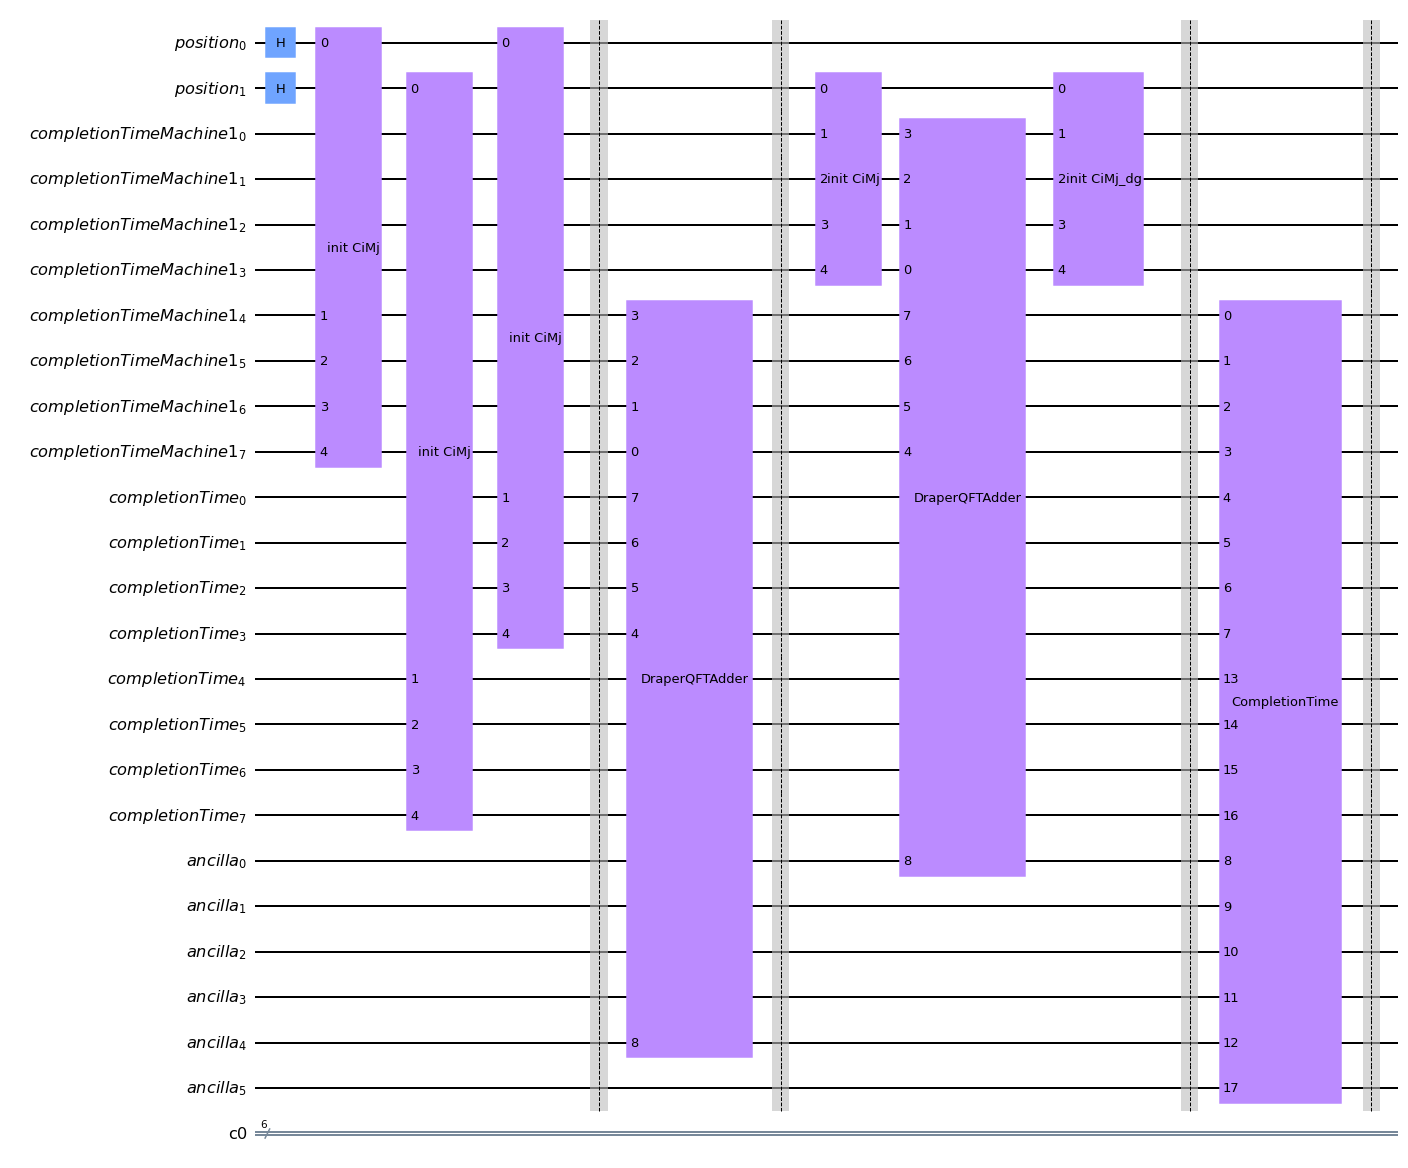

In [3]:
n = 1
q = 4
M = 2
x = [[1,2],[2,3]]
N=2**n


# init circuit
qubits =[]   
ancillaIndex = [i for i in range(N*n + 2*q + N*q*(M-1),N*n + 2*q + N*q*(M-1)+q+1)]
completionIndex = [0 for i in range(q)]
out = ClassicalRegister(6)
schedule = QuantumRegister(N*n,'position')
completionTimeMachine1 = QuantumRegister(2*q,'completionTimeMachine1')
completionTime = QuantumRegister(q*(M-1)*(N),'completionTime')
ancilla = QuantumRegister(q+2,'ancilla')
qc = QuantumCircuit(schedule,completionTimeMachine1,completionTime,ancilla,out)

qc.h([0,1])
# Initialization of all the completions times
positionIndex = [idx for idx in range(n)]
for l in range(q): 
    completionIndex[l]=N*n+q+l
qc.append(completionTimeInit(n,q,x[0]),positionIndex + completionIndex)
for i in range(N):
    positionIndex = [i*n + idx for idx in range(n)]
    for j in range(M-1):
        for l in range(q): 
            completionIndex[l] = N*n + 2*q + (i)*(M-1)*q + (j)*q + l
        qc.append(completionTimeInit(n,q,x[j+1]),positionIndex + completionIndex)
qc.barrier()


#compute the value of the completion of first job on each machine 
#machine 1 is a special case because it starts always at 0 while for other machines it depends on the previous machine

for i in range(1,M):
    for j in reversed(range(q)):
        qubits.append(N*n + q + (i-1)*q + j)
    for j in reversed(range(q,2*q)):
        qubits.append(N*n + q + (i-1)*q + j)
    qubits.append(N*n + 2*q + q*(M-1)*(N)+q)   
    qc.append(DraperQFTAdder(q, kind='half').to_gate(),qubits)
    qubits =[]   
qc.barrier()



#For the rest of the completion times we will apply the function ciMj
#Cij = Cij + max(Ci-1,j,,Ci,j-1) i>1 j>1
for i in range(1,N):
    positionIndex = [i*n + idx for idx in range(n)]
    for j in range(M):
        if j == 0 :
            #machine 1 we just need to do addition and init the first q qubits
            for l in range(q): 
                completionIndex[l]=N*n+l
            qc.append(completionTimeInit(n,q,x[0]),positionIndex + completionIndex)  
            completionIndex.reverse()
            qc.append(DraperQFTAdder(q, kind='half').to_gate(),completionIndex + [i for i in reversed(range(N*n +q,N*n+2*q))] + [N*n + 2*q + q*(M-1)*N])
            completionIndex.reverse()
            qc.append(completionTimeInit(n,q,x[0]).inverse(),positionIndex + completionIndex) 

        else :
            #c1,c2,ancilla,cmp,c3,carry
            if j == 1 :
                #completion 2 depends on completion 1 which is a special case in term of index
                qc.append(ciMj(q),[l for l in range(N*n + q, N*n + 2*q)] + [l for l in range(N*n+2*q+(i-1)*(M-1)*q,N*n+2*q+(i-1)*(M-1)*q+q)] + ancillaIndex+ [l for l in range(N*n+2*q+i*(M-1)*q,N*n+2*q+i*(M-1)*q+q)] + [N*n + 2*q + N*q*(M-1)+q+1])
            else :
                qc.append(ciMj(q), [l for l in range(N*n+2*q+(i-1)*(M-1)*q+(j-1)*q,N*n+2*q+(i-1)*(M-1)*q+(j-1)*q+q)] + [l for l in range(N*n+2*q+i*(M-1)*q+(j-2)*q,N*n+2*q+i*(M-1)*q+(j-2)*q+q)]  + ancillaIndex + [l for l in range(N*n+2*q+i*(M-1)*q+(j-1)*q,N*n+2*q+i*(M-1)*q+(j-1)*q+q)]+[N*n + 2*q + N*q*(M-1)+q+1])
        qc.barrier()
qc.draw("mpl")

In [4]:
qc.measure([0,1,14,15,16,17],out)
qc.draw()

┌───┐┌────────────┐              ┌────────────┐ ░ »
              position_0: ┤ H ├┤0           ├──────────────┤0           ├─░─»
                          ├───┤│            │┌────────────┐│            │ ░ »
              position_1: ┤ H ├┤            ├┤0           ├┤            ├─░─»
                          └───┘│            ││            ││            │ ░ »
completionTimeMachine1_0: ─────┤            ├┤            ├┤            ├─░─»
                               │            ││            ││            │ ░ »
completionTimeMachine1_1: ─────┤            ├┤            ├┤            ├─░─»
                               │            ││            ││            │ ░ »
completionTimeMachine1_2: ─────┤            ├┤            ├┤            ├─░─»
                               │  init CiMj ││            ││            │ ░ »
completionTimeMachine1_3: ─────┤            ├┤            ├┤            ├─░─»
                               │            ││            ││            │ ░ »
completionTimeMachine1_4: ─────┤1           ├┤            ├┤            ├─░─»
                               │            ││            ││  init CiMj │ ░ »
completionTimeMachine1_5: ─────┤2           ├┤            ├┤            ├─░─»
                               │            ││            ││            │ ░ »
completionTimeMachine1_6: ─────┤3           ├┤            ├┤            ├─░─»
                               │            ││            ││            │ ░ »
completionTimeMachine1_7: ─────┤4           ├┤  init CiMj ├┤            ├─░─»
                               └────────────┘│            ││            │ ░ »
        completionTime_0: ───────────────────┤            ├┤1           ├─░─»
                                             │            ││            │ ░ »
        completionTime_1: ───────────────────┤            ├┤2           ├─░─»
                                             │            ││            │ ░ »
        completionTime_2: ───────────────────┤            ├┤3           ├─░─»
                                             │            ││            │ ░ »
        completionTime_3: ───────────────────┤            ├┤4           ├─░─»
                                             │            │└────────────┘ ░ »
        completionTime_4: ───────────────────┤1           ├───────────────░─»
                                             │            │               ░ »
        completionTime_5: ───────────────────┤2           ├───────────────░─»
                                             │            │               ░ »
        completionTime_6: ───────────────────┤3           ├───────────────░─»
                                             │            │               ░ »
        completionTime_7: ───────────────────┤4           ├───────────────░─»
                                             └────────────┘               ░ »
               ancilla_0: ────────────────────────────────────────────────░─»
                                                                          ░ »
               ancilla_1: ────────────────────────────────────────────────░─»
                                                                          ░ »
               ancilla_2: ────────────────────────────────────────────────░─»
                                                                          ░ »
               ancilla_3: ────────────────────────────────────────────────░─»
                                                                          ░ »
               ancilla_4: ────────────────────────────────────────────────░─»
                                                                          ░ »
               ancilla_5: ────────────────────────────────────────────────░─»
                                                                          ░ »
                    c0: 6/══════════════════════════════════════════════════»
                                                                            »
«                                              ░

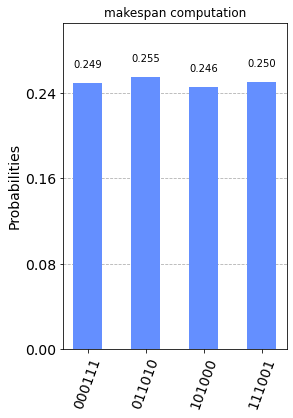

In [8]:
# Use Aer's qasm_simulator
simulator = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator
job = execute(qc, simulator, shots=5000)

# Grab results from the job
result = job.result()

# Return counts
counts = result.get_counts(qc)
plot_histogram(counts, figsize=(4, 6),title="makespan computation")